## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu")(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import fbeta_score #beta 設2即可
# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f2_tp"] = fbeta_score(y_true = y_true, y_pred = y_pred,beta=2, average="weighted")
        logs['val_f2_tn'] = 1-fbeta_score(y_true = y_true, y_pred = y_pred, beta=2,average="weighted")
        
rec_tptn = Record_tp_tn()

In [15]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_f2_tp']
valid_tn = model.history.history['val_f2_tn']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 822,410
Trainable params: 821,642
Non-trainable params: 768
_________________________________________________________________
Tr

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 7s 140us/step - loss: 1.7772 - acc: 0.3812 - val_loss: 1.8052 - val_acc: 0.3729
Epoch 3/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.6725 - acc: 0.4151 - val_loss: 1.7179 - val_acc: 0.3971
Epoch 4/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.6141 - acc: 0.4359 - val_loss: 1.6527 - val_acc: 0.4174
Epoch 5/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.5696 - acc: 0.4521 - val_loss: 1.6265 - val_acc: 0.4268
Epoch 6/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5368 - acc: 0.4643 - val_loss: 1.6053 - val_acc: 0.4361
Epoch 7/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5062 - acc: 0.4747 - val_loss: 1.5790 - val_acc: 0.4408
Epoch 8/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4811 - acc: 0.4828 - val_loss: 1.5619 - val_acc: 0.4492
Epoch 9/25
50000/50000 [=====================

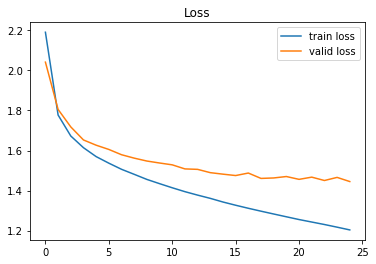

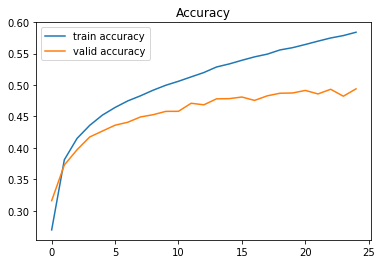

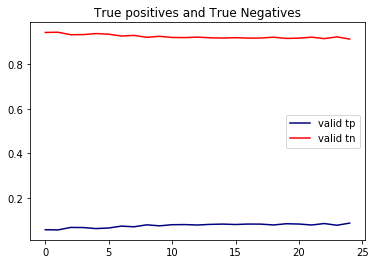

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
